In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, AveragePooling2D
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff
from fname_func import load_fnames, make_fnames

# MAXPOOLING
from create_fcn import create_fcn01, create_fcn00
# AVERAGE POOLING
#from create_fcn_avpool import create_fcn01,create_fcn00

np.random.seed(2016)

Using TensorFlow backend.


In [2]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    # dname_checkpoints = 'checkpoints_fcn00_avpool.augumented'
    dname_checkpoints = 'checkpoints_fcn00.augumented'
    # dname_checkpoints_fcn01 = 'checkpoints_fcn01_avpool'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # definision of mode, LEARN or TEST or SHOW_HISTORY
    #mode = "LEARN"
    #mode = "SHOW_HISTORY"
    #mode = "TEST"

    # モデルを作成
    print('creating model fcn00...')
    model_fcn00 = create_fcn00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)

creating model fcn00...


In [6]:
#
#   LEARNING MODE
#
    # Read Learning Data
#    fnames = load_fnames('data/list_train_01.txt')
#    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
#    fnames = load_fnames('data.nnlab/list_train_01.txt')
#    fnames = load_fnames('data/list_train_01.txt')
    fnames = load_fnames('data_augumented/list_train_01.txt')
#    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data.nnlab/image','data.nnlab/gt','')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')

    print('reading training data')
    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    print('reading traking gt data')
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
#    fnames = load_fnames('data/list_valid_01.txt')
#    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    fnames = load_fnames('data_augumented/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    
    print('reading validation data')
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)     

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

reading training data
reading traking gt data
reading validation data
==> 7800 training images loaded
==> 7800 training masks loaded
==> 1196 validation images loaded
==> 1196 validation masks loaded
computing mean and standard deviation...
==> mean: [125.60018   90.205666  77.57043 ]
==> std : [61.01421  47.890713 51.63054 ]


In [7]:
    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [8]:
    init_from_fcn01 = 0
    
    if init_from_fcn01 == 1:
        # モデルに学習済のfcn01 Weightをロードする
        model_fcn01 = create_fcn01(target_size)        
        epoch = 100
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
        model_fcn01.load_weights(fpath_weights_fcn01)
        #print('==> done')

        # load weights from Learned U-NET
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2',
                       'conv4_1','conv4_2','conv5_1', 'conv5_2',
                    'up1_1', 'up1_2', 'up2_1', 'up2_2', 'up3_1', 'up3_2', 'up4_1', 
                       'up4_2', 'conv_fin']
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2',
                    'up1_1', 'up1_2', 'up2_1', 'up2_2', 'conv_fin']

        print('copying layer weights')
        for name in layer_names:
            print(name)
            model_fcn00.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
            model_fcn00.get_layer(name).trainable = True

In [9]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_fcn00.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)      

In [10]:
    # トレーニングを開始
    print('start training...')
    history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=64, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])

start training...
Train on 7800 samples, validate on 1196 samples
Epoch 1/200
7800/7800 [==============================] - 353s 45ms/step - loss: -0.0991 - dice_coef: 0.0991 - val_loss: -0.2066 - val_dice_coef: 0.2066
Epoch 2/200
7800/7800 [==============================] - 310s 40ms/step - loss: -0.4541 - dice_coef: 0.4541 - val_loss: -0.4807 - val_dice_coef: 0.4807
Epoch 3/200
7800/7800 [==============================] - 310s 40ms/step - loss: -0.5364 - dice_coef: 0.5364 - val_loss: -0.5662 - val_dice_coef: 0.5662
Epoch 4/200
7800/7800 [==============================] - 310s 40ms/step - loss: -0.6253 - dice_coef: 0.6253 - val_loss: -0.6159 - val_dice_coef: 0.6159
Epoch 5/200
7800/7800 [==============================] - 310s 40ms/step - loss: -0.6579 - dice_coef: 0.6579 - val_loss: -0.6611 - val_dice_coef: 0.6611
Epoch 6/200
7800/7800 [==============================] - 310s 40ms/step - loss: -0.6710 - dice_coef: 0.6710 - val_loss: -0.6791 - val_dice_coef: 0.6791
Epoch 7/200
7800/7800 

7800/7800 [==============================] - 309s 40ms/step - loss: -0.9647 - dice_coef: 0.9647 - val_loss: -0.8073 - val_dice_coef: 0.8073
Epoch 108/200
7800/7800 [==============================] - 309s 40ms/step - loss: -0.9639 - dice_coef: 0.9639 - val_loss: -0.8069 - val_dice_coef: 0.8069
Epoch 109/200
7800/7800 [==============================] - 309s 40ms/step - loss: -0.9631 - dice_coef: 0.9631 - val_loss: -0.8064 - val_dice_coef: 0.8064
Epoch 110/200
7800/7800 [==============================] - 309s 40ms/step - loss: -0.9629 - dice_coef: 0.9629 - val_loss: -0.8036 - val_dice_coef: 0.8036
Epoch 111/200
7800/7800 [==============================] - 308s 40ms/step - loss: -0.9654 - dice_coef: 0.9654 - val_loss: -0.8045 - val_dice_coef: 0.8045
Epoch 112/200
7800/7800 [==============================] - 308s 40ms/step - loss: -0.9645 - dice_coef: 0.9645 - val_loss: -0.8051 - val_dice_coef: 0.8051
Epoch 113/200
7800/7800 [==============================] - 308s 40ms/step - loss: -0.9647 

KeyboardInterrupt: 

In [11]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

checkpoints_fcn00/history.pkl


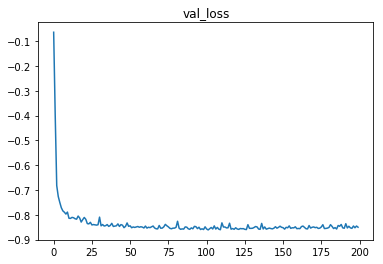

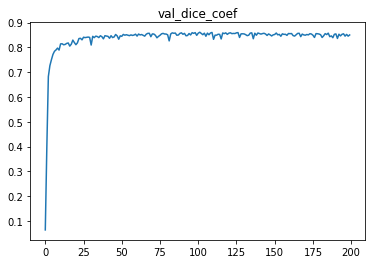

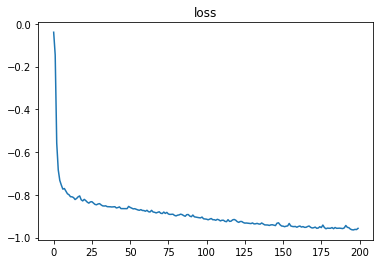

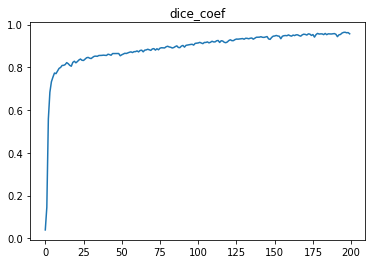

In [19]:
    #
    #   Show History
    #

    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))

    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()